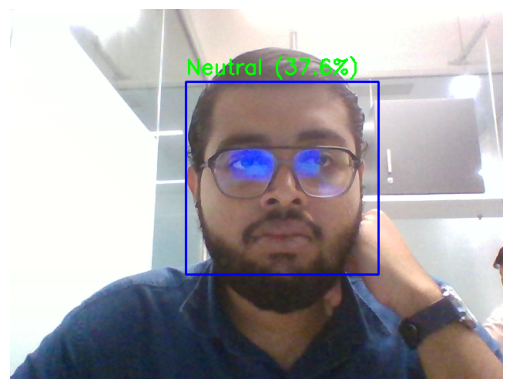

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from collections import deque
from IPython.display import display, clear_output
import yt_dlp
import vlc
import threading
import time

# 🎵 Map emotions to YouTube music links
emotion_music = {
    "happy": "https://www.youtube.com/watch?v=ZbZSe6N_BXs",        # Happy - Pharrell Williams
    "sad": "https://www.youtube.com/watch?v=ho9rZjlsyYY",          # Relaxing Sad Music
    "angry": "https://www.youtube.com/watch?v=ZkqyIoYAXV8",        # Rock Music for Anger
    "fear": "https://www.youtube.com/watch?v=_tV5LEBDs7w",         # Calming Piano Music
    "disgust": "https://www.youtube.com/watch?v=lFcSrYw-ARY",      # Meditation Music
    "surprise": "https://www.youtube.com/watch?v=QtXby3twMmI",     # Upbeat Party Music
    "neutral": "https://www.youtube.com/watch?v=jfKfPfyJRdk"       # Lofi Chill Beats
}

# 🧠 Smoothing: keep last 10 predictions for stability
pred_history = deque(maxlen=10)
current_emotion = None
music_player = None
vlc_instance = vlc.Instance()

# ✅ Load Haar cascade for face detection
haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)
print("✅ Haar Cascade loaded successfully")

def stream_youtube_audio(url):
    """Play YouTube audio using yt-dlp and VLC."""
    global music_player
    try:
        ydl_opts = {
            'format': 'bestaudio/best',
            'quiet': True,
            'noplaylist': True
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)
            audio_url = info['url']

        music_player = vlc_instance.media_player_new()
        media = vlc_instance.media_new(audio_url)
        music_player.set_media(media)
        music_player.play()
        print(f"🎵 Now Playing: {info['title']}")
    except Exception as e:
        print(f"❌ Error playing YouTube audio: {e}")

def play_music_for_emotion(emotion):
    """Start music for the detected emotion."""
    url = emotion_music.get(emotion)
    if url:
        stream_youtube_audio(url)
    else:
        print(f"🎵 No music mapped for emotion: {emotion}")

# ✅ Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("❌ Cannot open webcam")
else:
    print("✅ Webcam started. Stop the cell to exit.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to grab frame")
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        detected_emotion = None
        for (x, y, w, h) in faces:
            face_img = rgb_frame[y:y+h, x:x+w]

            # 🎯 Robust DeepFace Analysis
            try:
                analysis = DeepFace.analyze(face_img, actions=['emotion'], enforce_detection=False)
                emotion = analysis[0]['dominant_emotion']
                confidence = analysis[0]['emotion'][emotion]

                # 🧠 Add to history
                pred_history.append(emotion)
                smoothed_emotion = max(set(pred_history), key=pred_history.count)

                label = f"{smoothed_emotion.capitalize()} ({confidence:.1f}%)"
                detected_emotion = smoothed_emotion

                # 📦 Draw box and label
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(frame, label, (x, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            except Exception as e:
                print(f"⚠️ DeepFace error: {e}")

        # 🎵 Auto play music when emotion changes
        if detected_emotion and detected_emotion != current_emotion:
            current_emotion = detected_emotion
            print(f"🎶 Detected Emotion: {current_emotion}")
            if music_player and music_player.is_playing():
                music_player.stop()
            music_thread = threading.Thread(target=play_music_for_emotion, args=(current_emotion,))
            music_thread.start()

        # 📸 Show frame
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        display(plt.gcf())
        plt.clf()

except KeyboardInterrupt:
    print("🛑 Streaming stopped by user.")
finally:
    cap.release()
    if music_player:
        music_player.stop()
    print("✅ Webcam and music player released.")


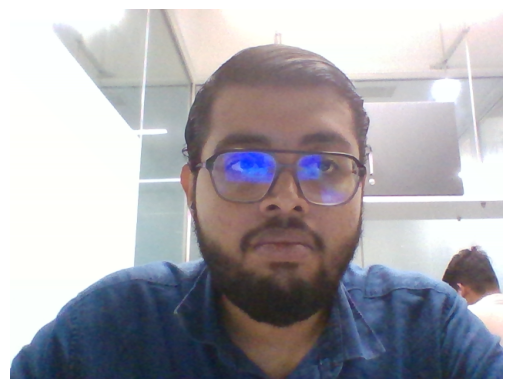

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from collections import deque, Counter
from IPython.display import display, clear_output
import yt_dlp
import vlc
import threading

# 🎵 Emotion to YouTube music mapping
emotion_music = {
    "happy": "https://www.youtube.com/watch?v=ZbZSe6N_BXs",        # Happy
    "sad": "https://www.youtube.com/watch?v=ho9rZjlsyYY",          # Sad
    "angry": "https://www.youtube.com/watch?v=ZkqyIoYAXV8",        # Angry
    "fear": "https://www.youtube.com/watch?v=_tV5LEBDs7w",         # Fear
    "disgust": "https://www.youtube.com/watch?v=lFcSrYw-ARY",      # Disgust
    "surprise": "https://www.youtube.com/watch?v=QtXby3twMmI",     # Surprise
    "neutral": "https://www.youtube.com/watch?v=jfKfPfyJRdk"       # Neutral
}

# 🧠 Longer history for prediction smoothing
pred_history = deque(maxlen=15)
current_emotion = None
music_player = None
vlc_instance = vlc.Instance()

# ✅ Load Haar cascade
haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)
print("✅ Haar Cascade loaded successfully")

def stream_youtube_audio(url):
    """Play YouTube audio using yt-dlp and VLC."""
    global music_player
    try:
        ydl_opts = {
            'format': 'bestaudio/best',
            'quiet': True,
            'noplaylist': True
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)
            audio_url = info['url']

        music_player = vlc_instance.media_player_new()
        media = vlc_instance.media_new(audio_url)
        music_player.set_media(media)
        music_player.play()
        print(f"🎵 Now Playing: {info['title']}")
    except Exception as e:
        print(f"❌ Error playing YouTube audio: {e}")

def play_music_for_emotion(emotion):
    """Play music for detected emotion."""
    url = emotion_music.get(emotion)
    if url:
        stream_youtube_audio(url)
    else:
        print(f"🎵 No music mapped for emotion: {emotion}")

# ✅ Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("❌ Cannot open webcam")
else:
    print("✅ Webcam started. Stop the cell to exit.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to grab frame")
            break

        # 📷 Preprocess frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)  # Improve contrast
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        detected_emotion = None
        for (x, y, w, h) in faces:
            # Slightly expand the box for better face capture
            padding = 20
            x1, y1 = max(x - padding, 0), max(y - padding, 0)
            x2, y2 = min(x + w + padding, frame.shape[1]), min(y + h + padding, frame.shape[0])
            face_img = rgb_frame[y1:y2, x1:x2]

            # 🎯 Analyze emotion with robust backend
            try:
                analysis = DeepFace.analyze(
                    face_img,
                    actions=['emotion'],
                    enforce_detection=False,
                    detector_backend='retinaface'
                )
                emotion = analysis['dominant_emotion']
                confidence = analysis['emotion'][emotion]

                # Add to history
                pred_history.append(emotion)
                # Get dominant emotion in history
                dominant_emotion = Counter(pred_history).most_common(1)[0]
                smoothed_emotion = dominant_emotion[0]
                frequency = dominant_emotion[1]

                label = f"{smoothed_emotion.capitalize()} ({confidence:.1f}%)"

                # Only consider emotion if it appeared >70% in history
                if frequency >= int(0.7 * pred_history.maxlen):
                    detected_emotion = smoothed_emotion

                # 📦 Draw box and label
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            except Exception as e:
                print(f"⚠️ DeepFace error: {e}")

        # 🎵 Play music only when robust emotion is detected
        if detected_emotion and detected_emotion != current_emotion:
            current_emotion = detected_emotion
            print(f"🎶 Robust Detected Emotion: {current_emotion}")
            if music_player and music_player.is_playing():
                music_player.stop()
            music_thread = threading.Thread(target=play_music_for_emotion, args=(current_emotion,))
            music_thread.start()

        # 📸 Show frame
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        display(plt.gcf())
        plt.clf()

except KeyboardInterrupt:
    print("🛑 Streaming stopped by user.")
finally:
    cap.release()
    if music_player:
        music_player.stop()
    print("✅ Webcam and music player released.")
